# Air Pollution Forecasting

https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate?select=LSTM-Multivariate_pollution.csv

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Dataset

In [4]:
raw = pd.read_csv('data/Multivariate_pollution.csv')

raw

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [5]:
# Convert 'date' column to datetime format
raw['date'] = pd.to_datetime(raw['date'])

# Set 'date' as index
raw.set_index('date', inplace=True)

# Select only numeric columns
raw_numeric = raw.select_dtypes(include='number')

# Aggregate by day (take daily mean)
df = raw_numeric.resample('D').mean()

# Show the result
df.head()

,pollution,dew,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


In [6]:
df.tail()

,pollution,dew,temp,press,wnd_spd,snow,rain
date,,,,,,,
2014-12-27,238.666667,-9.666667,-1.791667,1027.833333,9.278333,0.0,0.0
2014-12-28,197.375000,-10.791667,1.583333,1019.958333,10.948750,0.0,0.0
2014-12-29,159.000000,-12.333333,0.750000,1013.750000,8.000000,0.0,0.0
2014-12-30,46.083333,-13.916667,1.875000,1019.125000,9.778333,0.0,0.0
2014-12-31,10.041667,-21.791667,-1.916667,1032.125000,167.458333,0.0,0.0


In [7]:
df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,77.333112,14.163508,11.552997,10.076053,41.373161,0.546072,0.993917
min,0.000000,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000
25%,38.000000,-10.083333,1.541667,1007.916667,5.904167,0.000000,0.000000
50%,74.500000,2.041667,13.916667,1016.208333,10.953750,0.000000,0.000000
75%,126.166667,15.083333,23.166667,1024.541667,22.235000,0.000000,0.000000
max,529.458333,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dew        1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB


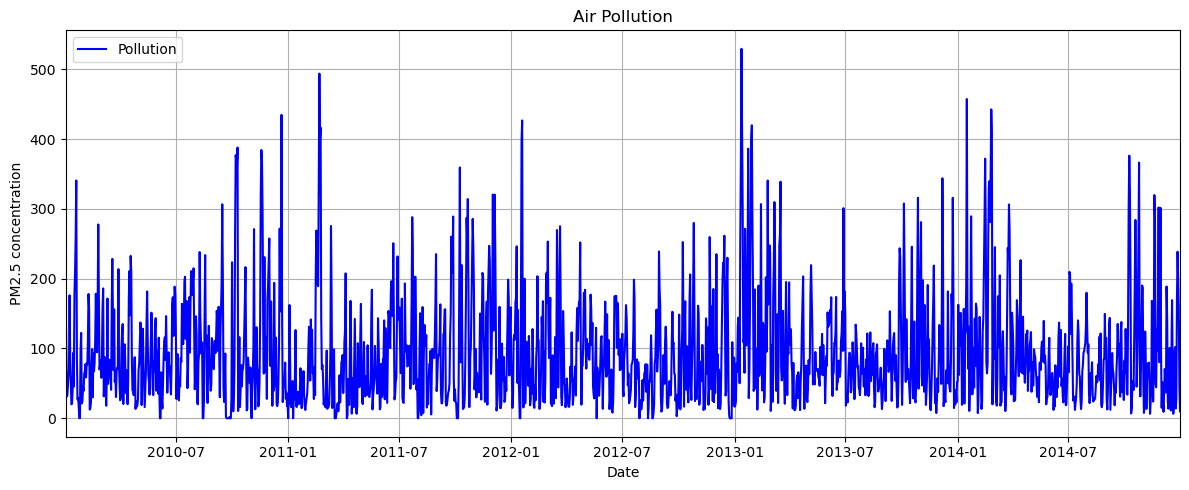

In [9]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(df.index, df['pollution'], label='Pollution', color='blue')     

plt.title('Air Pollution')                      
plt.xlabel('Date')                                        
plt.ylabel('PM2.5 concentration')  
plt.xlim(pd.to_datetime('2010-01-02'), pd.to_datetime('2014-12-31'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

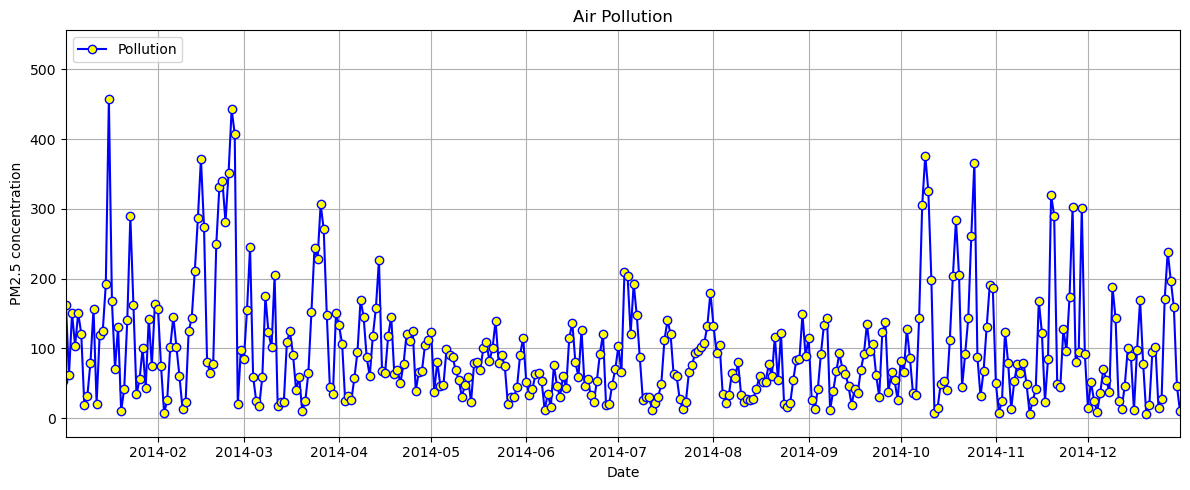

In [10]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(df.index, df['pollution'], label='Pollution', marker='o', markerfacecolor='yellow', color='blue')     

plt.title('Air Pollution')                      
plt.xlabel('Date')                                        
plt.ylabel('PM2.5 concentration')  
plt.xlim(pd.to_datetime('2014-01-02'), pd.to_datetime('2014-12-31'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

### Split in Train & Test datasets

In [11]:
# Split the data
cutoff = pd.to_datetime("2014-12-01")

train = df[df.index < cutoff]
test = df[df.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (1794, 7)
Test shape: (31, 7)

             pollution        dew      temp        press    wnd_spd  snow  \
date                                                                        
2014-11-26  302.166667  -0.250000  2.750000  1016.416667   2.305417   0.0   
2014-11-27   80.416667 -12.666667  5.500000  1023.708333   9.517917   0.0   
2014-11-28   95.375000  -5.500000  4.750000  1020.791667  13.615417   0.0   
2014-11-29  301.541667   0.041667  1.958333  1020.666667   3.611250   0.0   
2014-11-30   91.416667 -12.916667  3.500000  1023.291667  65.907083   0.0   

                rain  
date                  
2014-11-26  0.000000  
2014-11-27  0.000000  
2014-11-28  0.000000  
2014-11-29  0.041667  
2014-11-30  0.000000  

            pollution        dew      temp        press     wnd_spd  snow  \
date                                                                        
2014-12-01  15.041667 -22.375000 -3.541667  1031.750000  299.762500   0.0   
2014-12-02  51.791667 -

# SARIMA Model

In [12]:
pol_series = train['pollution']

len(pol_series)

1794

### Find 'd'

In [13]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  


d = determine_nonseasonal_d(pol_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -19.2994, p-value = 0.0000

Non-seasonal differencing term (d): 0


### Find 'S'

In [14]:
def detect_seasonal(series):

    # Apply Fourier Transform
    fourier = np.fft.fft(series - np.mean(series))
    frequencies = np.fft.fftfreq(len(series))

    # Identify the most significant frequency (ignoring the 0 frequency)
    positive_freqs = frequencies[np.where(frequencies > 0)]
    significant_freq = positive_freqs[np.argmax(np.abs(fourier[1:len(positive_freqs)+1]))]

    # Calculate the seasonal period (S)
    S = int(1 / significant_freq)

    return print(f"Detected Seasonal Period: S = {S}")

detect_seasonal(pol_series)

Detected Seasonal Period: S = 119


### Check possible S's

In [15]:
def detect_top_seasonal_periods(series, top_n=5):
    import numpy as np
    import pandas as pd

    # Remove mean to center the series
    series_detrended = series - np.mean(series)

    # Apply Fourier Transform
    fourier = np.fft.fft(series_detrended)
    frequencies = np.fft.fftfreq(len(series))

    # Only keep positive frequencies (exclude zero)
    positive_mask = frequencies > 0
    positive_freqs = frequencies[positive_mask]
    magnitudes = np.abs(fourier[positive_mask])

    # Get indices of top N magnitudes
    top_indices = np.argsort(magnitudes)[-top_n:][::-1]

    # Prepare result
    top_periods = [(round(1 / positive_freqs[i], 2), magnitudes[i]) for i in top_indices]

    # Display results
    print("Top Seasonal Periods (in time units):")
    for i, (period, magnitude) in enumerate(top_periods, 1):
        print(f"{i}. Period = {period} (Frequency = {round(positive_freqs[top_indices[i-1]], 5)}), Magnitude = {round(magnitude, 2)}")


detect_top_seasonal_periods(pol_series, top_n=10)

Top Seasonal Periods (in time units):
1. Period = 119.6 (Frequency = 0.00836), Magnitude = 13487.75
2. Period = 11.21 (Frequency = 0.08919), Magnitude = 12011.63
3. Period = 448.5 (Frequency = 0.00223), Magnitude = 11968.91
4. Period = 358.8 (Frequency = 0.00279), Magnitude = 11671.11
5. Period = 22.15 (Frequency = 0.04515), Magnitude = 11659.69
6. Period = 299.0 (Frequency = 0.00334), Magnitude = 10829.4
7. Period = 40.77 (Frequency = 0.02453), Magnitude = 10254.68
8. Period = 7.63 (Frequency = 0.13099), Magnitude = 9874.45
9. Period = 15.74 (Frequency = 0.06355), Magnitude = 9769.94
10. Period = 30.41 (Frequency = 0.03289), Magnitude = 9272.13


### Find 'D'

In [16]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [7, 30, 52, 365]:

    D = determine_seasonal_D(pol_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0
Seasonal differencing term (D) for 365: 2


### Check Seasonal 'D'

In [17]:
def test_seasonal(series, m=12):

    ch = nsdiffs(series, m=m, test='ch')
    ocsb = nsdiffs(series, m=m, test='ocsb')

    print('                Canova-Hansen test:', ch)
    print('Osborn-Chui-Smith-Birchenhall test:', ocsb)

    D = min(ch, ocsb)  

    return D

test_seasonal(series=pol_series, m=7)

                Canova-Hansen test: 0
Osborn-Chui-Smith-Birchenhall test: 0


0

### Seasonal Decomposition

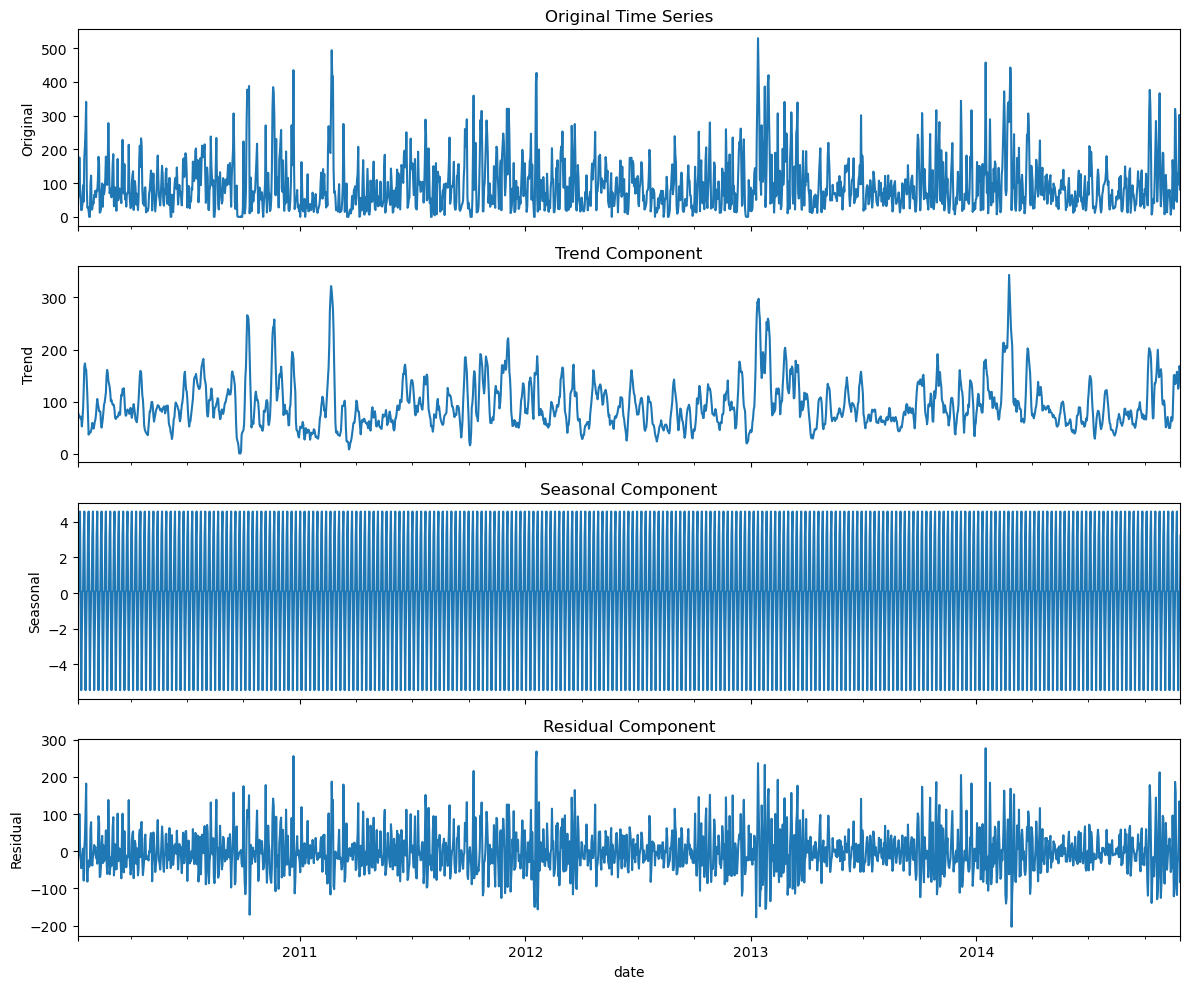

In [18]:
result = seasonal_decompose(pol_series, model='aditive', period=7)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

### Model

In [19]:
def best_auto_arima(series, d=0, D=0, S=12):

    # Perform a full search over the same grid as your manual SARIMAX model
    auto_model = pm.auto_arima(
        series,                     # The time series data
        seasonal=True,              # Enable seasonal component
        m=S,                        # Seasonal period
        d=d,                        # Set differencing 
        D=D,                        # Set seasonal differencing
        start_p=0, max_p=3,         # p 
        start_q=0, max_q=3,         # q 
        start_P=0, max_P=3,         # P 
        start_Q=0, max_Q=3,         # Q 
        stepwise=False,             # Disable stepwise search (enable full grid search)
        trace=False,                # Print model search progress
        error_action='ignore',      # Ignore errors and continue
        suppress_warnings=True,     # Suppress convergence warnings
        information_criterion='aic' # Use AIC to choose the best model
    )

    # Print the best model found
    print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

best_auto_arima(pol_series, d=0, D=0, S=7)

Best model: SARIMA(1, 0, 1)(0, 0, 0, 7)


In [20]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]       # Generate Cartesian product of input lists
    return combo                                         # Return the list of combinations


def find_best(series, d=0, D=0, S=12):

    P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]              # Define search ranges for non-seasonal parameters (p, q)
    P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]                # Define search ranges for seasonal parameters (P, Q)


    total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
    print(f'Total number of models: {total}')

    vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

    score = {}                                           # Dictionary to store model evaluation metrics

    for i, (p, d, q, P, D, Q) in enumerate(vals):        # Iterate over all parameter combinations
    
        if i % 15 == 0:                                  # Print progress every 15 models
            print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

        m = SARIMAX(series,                              # Define SARIMA model with current parameter set
                    order=(p,d,q), 
                    seasonal_order=(P, D, Q, S),   
                    enforce_stationarity=False)          # Allow non-stationary models for broader search

        res = m.fit(disp=0, low_memory=True)             # Fit the model silently

        score[i] = {                                     # Store model results and evaluation metrics
            'non-seasonal order': (p, d, q),      
            'seasonal order': (P, D, Q),
            'AIC': res.aic,                              # Akaike Information Criterion
        }
        
    print("\nBest models by AIC:")
    best_models = pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()
    print(best_models)


find_best(series=pol_series, d=0, D=0, S=7)

Total number of models: 256
Running model #0 using SARIMA(0,0,0)(0,0,0,7)
Running model #15 using SARIMA(0,0,0)(3,0,3,7)
Running model #30 using SARIMA(0,0,1)(3,0,2,7)
Running model #45 using SARIMA(0,0,2)(3,0,1,7)
Running model #60 using SARIMA(0,0,3)(3,0,0,7)
Running model #75 using SARIMA(1,0,0)(2,0,3,7)
Running model #90 using SARIMA(1,0,1)(2,0,2,7)
Running model #105 using SARIMA(1,0,2)(2,0,1,7)
Running model #120 using SARIMA(1,0,3)(2,0,0,7)
Running model #135 using SARIMA(2,0,0)(1,0,3,7)
Running model #150 using SARIMA(2,0,1)(1,0,2,7)
Running model #165 using SARIMA(2,0,2)(1,0,1,7)
Running model #180 using SARIMA(2,0,3)(1,0,0,7)
Running model #195 using SARIMA(3,0,0)(0,0,3,7)
Running model #210 using SARIMA(3,0,1)(0,0,2,7)
Running model #225 using SARIMA(3,0,2)(0,0,1,7)
Running model #240 using SARIMA(3,0,3)(0,0,0,7)
Running model #255 using SARIMA(3,0,3)(3,0,3,7)

Best models by AIC:
   index non-seasonal order seasonal order           AIC
0    243          (3, 0, 3)      (0, 0

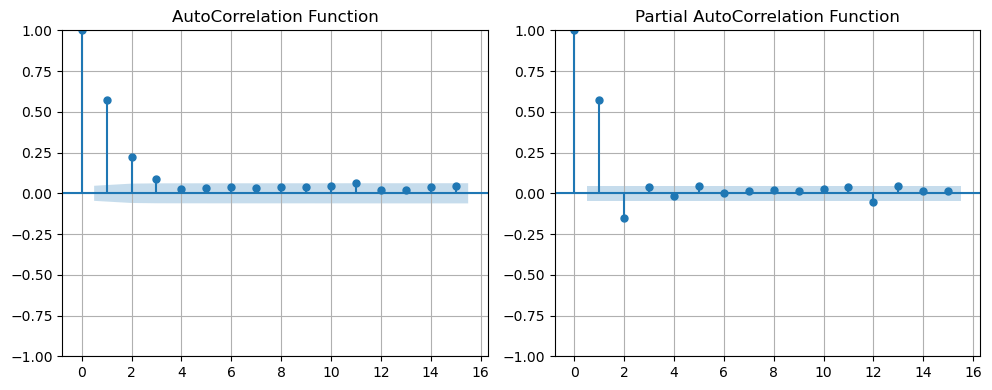

In [21]:
def acf_and_pacf(series, lagsn=15):

    # Create a 1x2 grid for subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

    # Plot AutoCorrelation Function
    plot_acf(series, ax=axes[0], lags=lagsn)
    axes[0].set_title("AutoCorrelation Function", fontsize=12)
    axes[0].grid(True)

    # Plot Partial Autocorrelation Function
    plot_pacf(series, ax=axes[1], lags=lagsn)
    axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


acf_and_pacf(pol_series, lagsn=15)

In [22]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_303 = SARIMAX(endog=train['pollution'],       # Time series data
                    order=(3, 0, 3),                # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 3, 7),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_303 = model_303.fit()

# Display summary of the model
print(model_fit_303.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         pollution   No. Observations:                 1794
Model:             SARIMAX(3, 0, 3)x(0, 0, 3, 7)   Log Likelihood               -9838.564
Date:                           Fri, 30 May 2025   AIC                          19697.128
Time:                                   09:37:55   BIC                          19751.910
Sample:                               01-02-2010   HQIC                         19717.368
                                    - 11-30-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5246      0.117      4.471      0.000       0.295       0.755
ar.L2          0.8568      0.145      5.912

In [23]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_303)

ma.L1 coefficient: 0.1451
ma.L1 95% CI: (-0.0897, 0.3800)
ma.L1 p-value: 0.2258
ma.L1 is statistically IRRELEVANT in the model.

ma.S.L7 coefficient: -0.0110
ma.S.L7 95% CI: (-0.0582, 0.0363)
ma.S.L7 p-value: 0.6494
ma.S.L7 is statistically IRRELEVANT in the model.

ma.S.L14 coefficient: 0.0210
ma.S.L14 95% CI: (-0.0287, 0.0707)
ma.S.L14 p-value: 0.4074
ma.S.L14 is statistically IRRELEVANT in the model.

ma.S.L21 coefficient: 0.0219
ma.S.L21 95% CI: (-0.0275, 0.0713)
ma.S.L21 p-value: 0.3847
ma.S.L21 is statistically IRRELEVANT in the model.



In [24]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_000 = SARIMAX(endog=train['pollution'],       # Time series data
                    order=(3, 0, 3),                # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 0, 7),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_000 = model_000.fit()

# Display summary of the model
print(model_fit_000.summary())

                               SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                 1794
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -9955.294
Date:                Fri, 30 May 2025   AIC                          19924.588
Time:                        09:37:56   BIC                          19963.018
Sample:                    01-02-2010   HQIC                         19938.778
                         - 11-30-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4244      0.035     12.116      0.000       0.356       0.493
ar.L2          0.9699      0.014     67.608      0.000       0.942       0.998
ar.L3         -0.3942      0.031    -12.862      0.0

In [25]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_000)

ma.L1 coefficient: 0.2286
ma.L1 95% CI: (-0.4033, 0.8605)
ma.L1 p-value: 0.4782
ma.L1 is statistically IRRELEVANT in the model.



### Residual Analysis

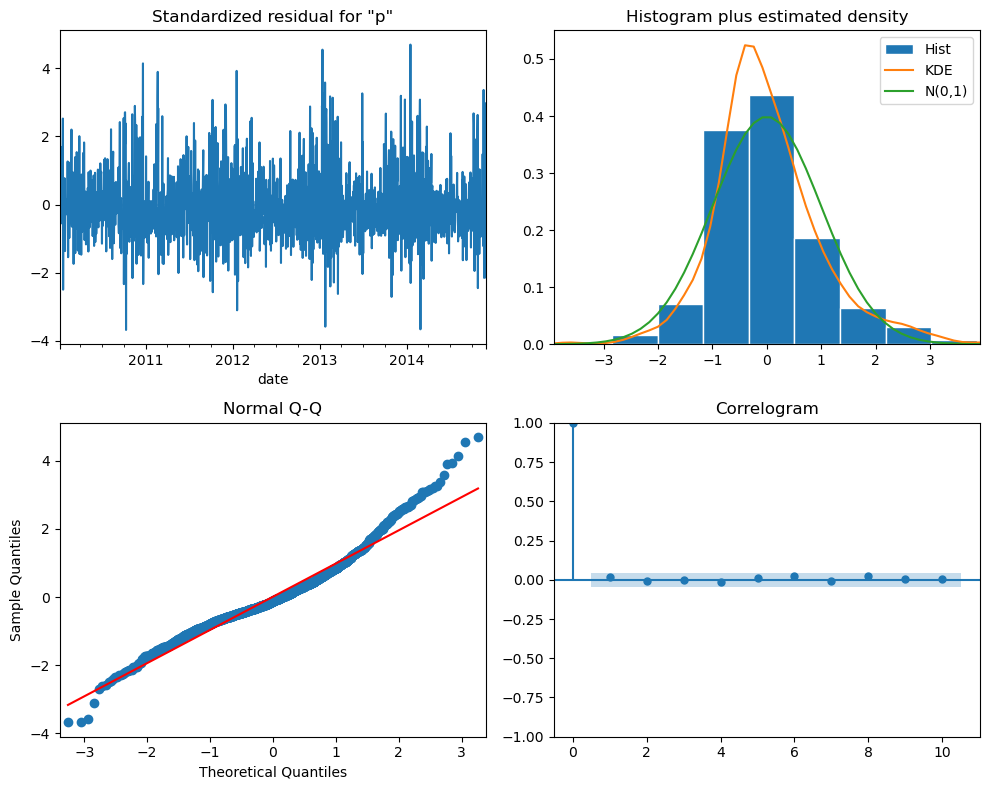

In [26]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_000.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [27]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_000.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.502345,0.478471
2,0.729128,0.694499
3,0.733540,0.865288
4,1.375181,0.848497
5,1.685307,0.890746
6,2.873605,0.824535
7,2.932135,0.891208
8,4.109564,0.847105
9,4.185579,0.898779
10,4.275413,0.934069


In [28]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.9609
Conclusion: No significant autocorrelation.


### Forecasting

In [29]:
# Forecast the next Time points
forecast_S = model_fit_000.get_forecast(steps=test.shape[0])

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()        

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values                 # Forecast mean

test['Error S'] = test['Forecast S'] - test['pollution']

test['Lower 95% CI S'] = conf_int_S.iloc[:, 0].values       # Lower bound
test['Upper 95% CI S'] = conf_int_S.iloc[:, 1].values       # Upper bound

# Show the updated test DataFrame
test.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
date,,,,,,,,,,,
2014-12-01,15.041667,-22.375000,-3.541667,1031.750000,299.762500,0.0,0.0,62.907396,47.865729,-63.264571,189.079362
2014-12-02,51.791667,-19.500000,-5.000000,1027.833333,38.071250,0.0,0.0,82.361580,30.569914,-68.366412,233.089572
2014-12-03,25.375000,-22.250000,-2.791667,1026.625000,53.080417,0.0,0.0,90.578879,65.203879,-63.486183,244.643941
2014-12-04,9.208333,-22.416667,-2.000000,1027.375000,60.924583,0.0,0.0,93.520019,84.311685,-61.209783,248.249821
2014-12-05,35.541667,-20.250000,-2.750000,1027.208333,14.563333,0.0,0.0,95.068475,59.526809,-59.726799,249.863750


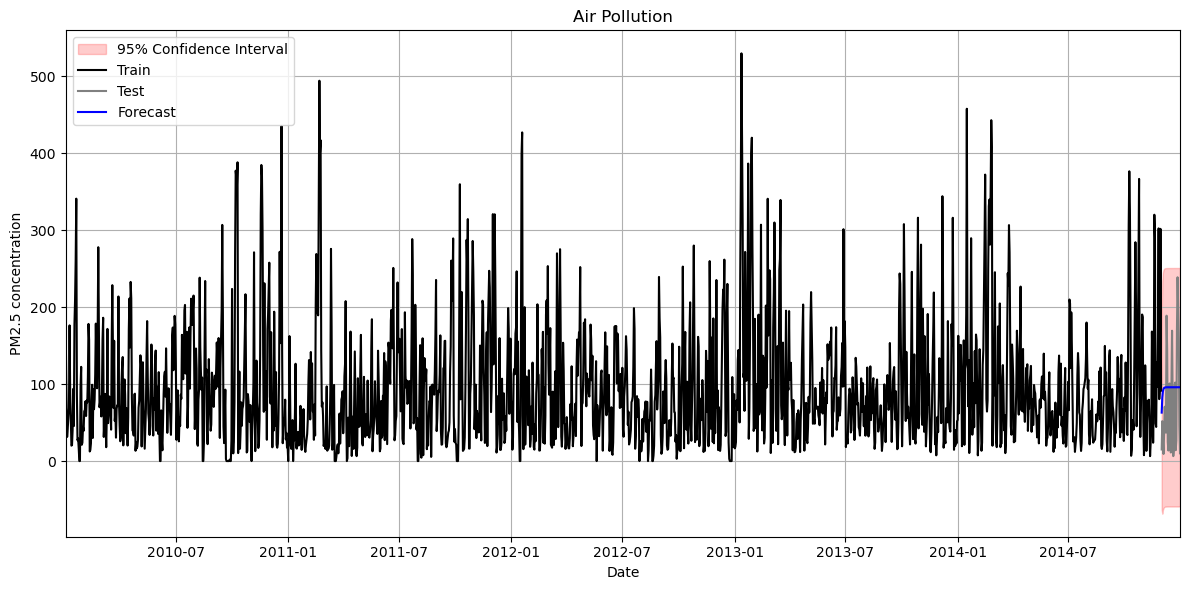

In [30]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['pollution'], label='Train', color='black')      # Train
plt.plot(test.index, test['pollution'], label='Test', color='gray')          # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Air Pollution')                      
plt.xlabel('Date')                                        
plt.ylabel('PM2.5 concentration')  
plt.xlim(pd.to_datetime('2010-01-02'), pd.to_datetime('2014-12-31'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

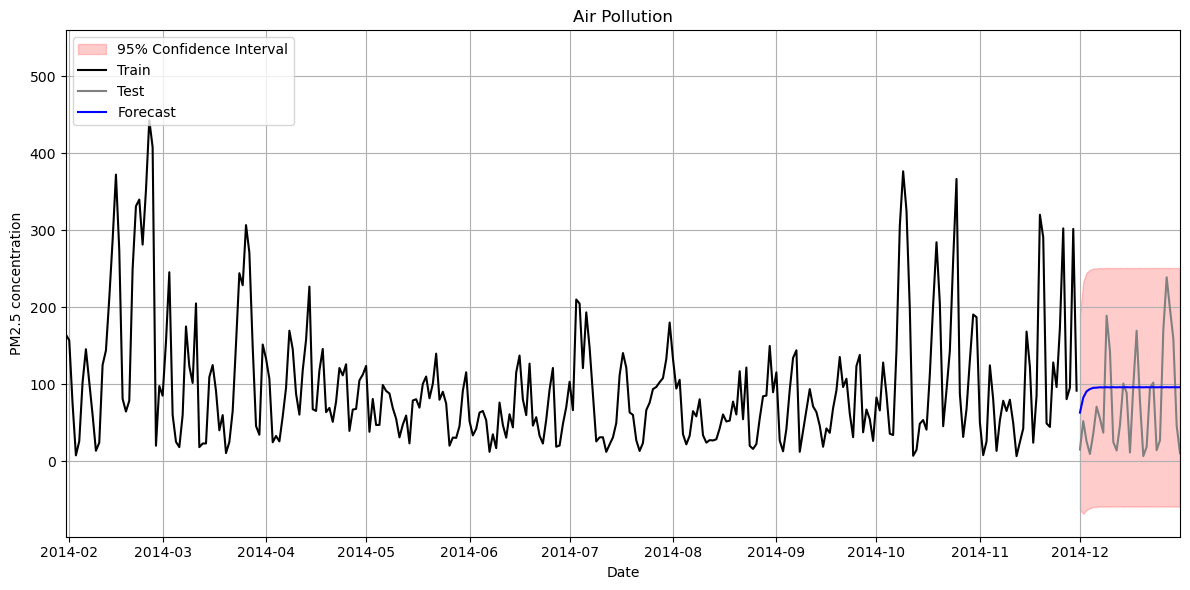

In [31]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['pollution'], label='Train', color='black')      # Train
plt.plot(test.index, test['pollution'], label='Test', color='gray')          # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Air Pollution')                      
plt.xlabel('Date')                                        
plt.ylabel('PM2.5 concentration')  
plt.xlim(pd.to_datetime('2014-01-31'), pd.to_datetime('2014-12-31'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

# SARIMAX Model - Exogenous Variables

### Gauger Causality Test

In [32]:
### Gauger Causality Test

from statsmodels.tsa.stattools import grangercausalitytests

def prepare_granger_data_multi(y, X, d=0, D=0, S=12):

    # Apply seasonal differencing D times to y and all columns in X
    for _ in range(D):
        y = y.diff(S)
        X = X.diff(S)

    # Apply regular differencing d times
    for _ in range(d):
        y = y.diff()
        X = X.diff()

    # Drop missing values
    y = y.dropna()
    X = X.dropna()

    # Concatenate and align
    df = pd.concat([y] + [X[col] for col in X.columns], axis=1).dropna()
    df.columns = [y.name] + list(X.columns)

    return df

# Assume y is a Series and X is a DataFrame with multiple exogenous variables
y = train['pollution']                                       #<================== Parameters
X = train[['dew','temp','press','snow','rain']]              #<================== Parameters

# Prepare data
df_granger = prepare_granger_data_multi(y, X, d=0, D=0, S=7) #<================== Parameters

def summarize_granger_results(df, target_col, maxlag=7, alpha=0.05):

    results = []

    # Loop through all exogenous variables
    for col in df.columns:
        if col == target_col:
            continue  # skip the dependent variable

        # Run Granger test
        test_result = grangercausalitytests(df[[target_col, col]], maxlag=maxlag, verbose=False)

        # Extract p-values from ssr_chi2test for each lag
        p_values = [round(test_result[lag][0]['ssr_chi2test'][1], 4) for lag in range(1, maxlag+1)]

        # Find best (lowest) p-value and corresponding lag
        min_p = min(p_values)
        best_lag = p_values.index(min_p) + 1  # lags start at 1

        # Flag if variable Granger-causes the target
        granger_causes = 'Yes' if min_p < alpha else 'No'

        results.append({
            'Exogenous Variable': col,
            'Min p-value': min_p,
            'Best Lag': best_lag,
            'Granger-Causes ' + target_col: granger_causes
        })

    # Convert to DataFrame and set index
    summary_df = pd.DataFrame(results)
    summary_df.set_index('Exogenous Variable', inplace=True)

    return summary_df

# df_granger deve conter target + exógenas
summary = summarize_granger_results(df_granger, target_col='temp', maxlag=7)
summary

,Min p-value,Best Lag,Granger-Causes temp
Exogenous Variable,,,
pollution,0.0000,1,Yes
dew,0.0000,1,Yes
press,0.0000,1,Yes
snow,0.0124,2,Yes
rain,0.0000,1,Yes


### Transfer Entropy

In [33]:
from sklearn.preprocessing import KBinsDiscretizer
from pyinform.transferentropy import transfer_entropy


# Function to compute and interpret TE from each X column to y
def compute_te_to_y(y, X, bins=5, k=1):
    results = []  # To store results

    # Discretize y
    y_vals = y.values.reshape(-1, 1)
    discretizer_y = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    y_binned = discretizer_y.fit_transform(y_vals).astype(int).flatten()

    for col in X.columns:
        # Discretize each X column
        x_vals = X[col].values.reshape(-1, 1)
        discretizer_x = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
        x_binned = discretizer_x.fit_transform(x_vals).astype(int).flatten()

        # Ensure equal lengths
        min_len = min(len(x_binned), len(y_binned))
        x_binned = x_binned[:min_len]
        y_binned = y_binned[:min_len]

        # Compute transfer entropy X → y
        try:
            te = transfer_entropy(x_binned, y_binned, k=k)
        except:
            te = float('nan')  # Handle edge cases (e.g., constant sequences)

        # Interpret strength
        if te >= 0.5:
            level = "STRONG"
        elif te >= 0.2:
            level = "MODERATE"
        elif te > 0.05:
            level = "WEAK"
        else:
            level = "NEGLIGIBLE"

        # Store results
        results.append((col, round(te, 4), level))

    return results

y = train['pollution']                                       #<================== Parameters
X = train[['dew','temp','press','snow','rain']]              #<================== Parameters

results = compute_te_to_y(y, X)

# Display results
df_results = pd.DataFrame(results, columns=['Variable', 'Transfer Entropy to y', 'Interpretation'])
df_results.sort_values(by='Transfer Entropy to y', ascending=False, inplace=True)
df_results.set_index('Variable', inplace=True)
df_results

,Transfer Entropy to y,Interpretation
Variable,,
press,0.0460,NEGLIGIBLE
temp,0.0395,NEGLIGIBLE
dew,0.0353,NEGLIGIBLE
rain,0.0055,NEGLIGIBLE
snow,0.0032,NEGLIGIBLE


### Cross-Correlation Function (CCF)

In [34]:
from statsmodels.tsa.stattools import ccf


# Function to calculate the best positive lag and its corresponding correlation
def best_ccf(x, y, max_lag=20):
    aligned = pd.concat([x, y], axis=1).dropna()                                          # Drop NaNs and align x and y
    x_vals = (aligned.iloc[:, 0] - aligned.iloc[:, 0].mean()) / aligned.iloc[:, 0].std()  # Standardize x
    y_vals = (aligned.iloc[:, 1] - aligned.iloc[:, 1].mean()) / aligned.iloc[:, 1].std()  # Standardize y
    corr_values = ccf(x_vals, y_vals)[:max_lag + 1]                                       # Compute CCF for positive lags only
    best_lag = np.argmax(np.abs(corr_values[1:])) + 1                                     # Get the best lag > 0
    return best_lag, corr_values[best_lag]                                                # Return best lag and its correlation

# Function to interpret correlation strength
def interpret_correlation(corr):
    abs_corr = abs(corr)
    if abs_corr >= 0.7:
        return "STRONG"
    elif abs_corr >= 0.4:
        return "MODERATE"
    elif abs_corr >= 0.2:
        return "WEAK"
    else:
        return "NEGLIGIBLE"

# Data
y = train['pollution']                            #<================== Parameters
X = train[['dew','temp','press','snow','rain']]   #<================== Parameters
max_lag = 30                                      #<================== Maximum lag to consider

# Loop to apply the function to each variable in X 
results = []
for col in X.columns:
    lag, corr = best_ccf(X[col], y, max_lag=max_lag)                       # Apply the function
    results.append({
        "Variable": col,                                                   # Variable name
        "Best Lag": lag,                                                   # Best lag
        "Correlation": round(corr, 4),                                     # Corresponding correlation
        "Interpretation": interpret_correlation(corr)                      # Automatic interpretation
    })

# Create and sort summary DataFrame
df_ccf_summary = pd.DataFrame(results).set_index("Variable")              # Set variable name as index
df_ccf_summary = df_ccf_summary.sort_values(by="Correlation", ascending=False)  # Sort by correlation

# Display the final result
df_ccf_summary

,Best Lag,Correlation,Interpretation
Variable,,,
press,26,0.1291,NEGLIGIBLE
snow,1,0.0592,NEGLIGIBLE
rain,21,-0.0605,NEGLIGIBLE
temp,10,-0.1300,NEGLIGIBLE
dew,19,-0.1393,NEGLIGIBLE


### Variance Inflation Factor (VIF)

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create candidates dataframe
candidates = train[['dew','temp','press','snow','rain']]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = candidates.columns
vif_data["VIF"] = [round(variance_inflation_factor(candidates.values, i), 2) for i in range(len(candidates.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

           VIF              Interpretation
Feature                                   
dew       6.05  Moderate Multicollinearity
temp     12.81      High Multicollinearity
press     6.68  Moderate Multicollinearity
snow      1.06       Not Multicollinearity
rain      1.10       Not Multicollinearity



    Granger Causality: All
     Transfer Entropy: 'press', 'dew', 'temp'
                  CCF: All NEGLIGIBLE
                  VIF: 'dew', 'press', 'snow', 'rain'

             Selected: 'dew', 'press'

In [36]:
# Target variable selection
endog_data = train['pollution'] 

# Multiple column selection
exog_data = train[['dew', 'press']]  

In [37]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(3, 0, 3),               
                  seasonal_order=(0, 0, 0, 7),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                               SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                 1794
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -9604.392
Date:                Fri, 30 May 2025   AIC                          19226.783
Time:                        09:37:59   BIC                          19276.193
Sample:                    01-02-2010   HQIC                         19245.028
                         - 11-30-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            9.4426      0.410     23.057      0.000       8.640      10.245
press         -0.9167      0.518     -1.768      0.077      -1.933       0.099
ar.L1          0.4246      0.314      1.351      0.1

In [38]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_M)

press coefficient: -0.9167
press 95% CI: (-1.9330, 0.0995)
press p-value: 0.0770
press is statistically IRRELEVANT in the model.

ar.L1 coefficient: 0.4246
ar.L1 95% CI: (-0.1913, 1.0405)
ar.L1 p-value: 0.1766
ar.L1 is statistically IRRELEVANT in the model.

ma.L1 coefficient: 0.2597
ma.L1 95% CI: (-0.3634, 0.8828)
ma.L1 p-value: 0.4139
ma.L1 is statistically IRRELEVANT in the model.

ma.L3 coefficient: -0.1616
ma.L3 95% CI: (-0.3701, 0.0469)
ma.L3 p-value: 0.1288
ma.L3 is statistically IRRELEVANT in the model.



In [39]:
endog_data = train['pollution']   # Target variable selection
exog_data = train[['dew']]        # Multiple column selection

# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(3, 0, 3),               
                  seasonal_order=(0, 0, 0, 7),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                               SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                 1794
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -9603.525
Date:                Fri, 30 May 2025   AIC                          19223.050
Time:                        09:38:01   BIC                          19266.969
Sample:                    01-02-2010   HQIC                         19239.267
                         - 11-30-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            9.6015      0.357     26.927      0.000       8.903      10.300
ar.L1          0.3693      0.177      2.084      0.037       0.022       0.717
ar.L2          0.8834      0.168      5.263      0.0

In [40]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_M)

ma.L1 coefficient: 0.3020
ma.L1 95% CI: (-0.0501, 0.6541)
ma.L1 p-value: 0.0928
ma.L1 is statistically IRRELEVANT in the model.



### Residual Analysis

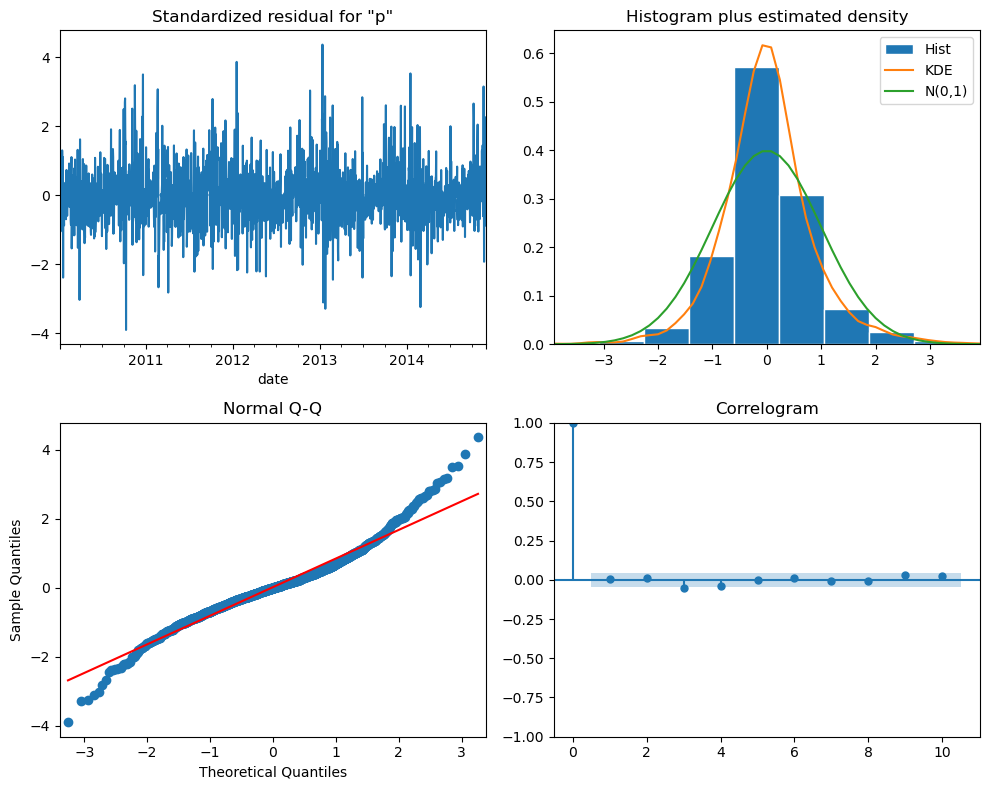

In [41]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [42]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.122932,0.725876
2,0.428973,0.806956
3,4.321916,0.228736
4,7.040511,0.133763
5,7.041567,0.217567
6,7.315448,0.292657
7,7.750158,0.355139
8,7.895856,0.443709
9,9.329537,0.407428
10,10.176014,0.425189


In [43]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.9708
Conclusion: No significant autocorrelation.


    Alternative:

```Python
# Forecast dew
dew_model = SARIMAX(train['dew'], order=(1, 1, 1), seasonal_order=(1, 0, 0, 365)).fit()
dew_forecast = dew_model.get_forecast(steps=len(test))
forecasted_dew = dew_forecast.predicted_mean

# Recria exog_test com dew previsto
exog_test_M = pd.DataFrame({'dew': forecasted_dew})
```

In [44]:
# Must match the structure of training exog
exog_test_M = test[['dew']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=test.shape[0], exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['pollution']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
date,,,,,,,,,,,,,,,
2014-12-01,15.041667,-22.375000,-3.541667,1031.750000,299.762500,0.0,0.0,62.907396,47.865729,-63.264571,189.079362,-21.444501,-36.486167,-139.845442,96.956441
2014-12-02,51.791667,-19.500000,-5.000000,1027.833333,38.071250,0.0,0.0,82.361580,30.569914,-68.366412,233.089572,8.414641,-43.377025,-134.188883,151.018166
2014-12-03,25.375000,-22.250000,-2.791667,1026.625000,53.080417,0.0,0.0,90.578879,65.203879,-63.486183,244.643941,-18.013542,-43.388542,-166.997196,130.970112
2014-12-04,9.208333,-22.416667,-2.000000,1027.375000,60.924583,0.0,0.0,93.520019,84.311685,-61.209783,248.249821,-20.042750,-29.251083,-173.056313,132.970814
2014-12-05,35.541667,-20.250000,-2.750000,1027.208333,14.563333,0.0,0.0,95.068475,59.526809,-59.726799,249.863750,-0.000694,-35.542361,-156.021946,156.020558


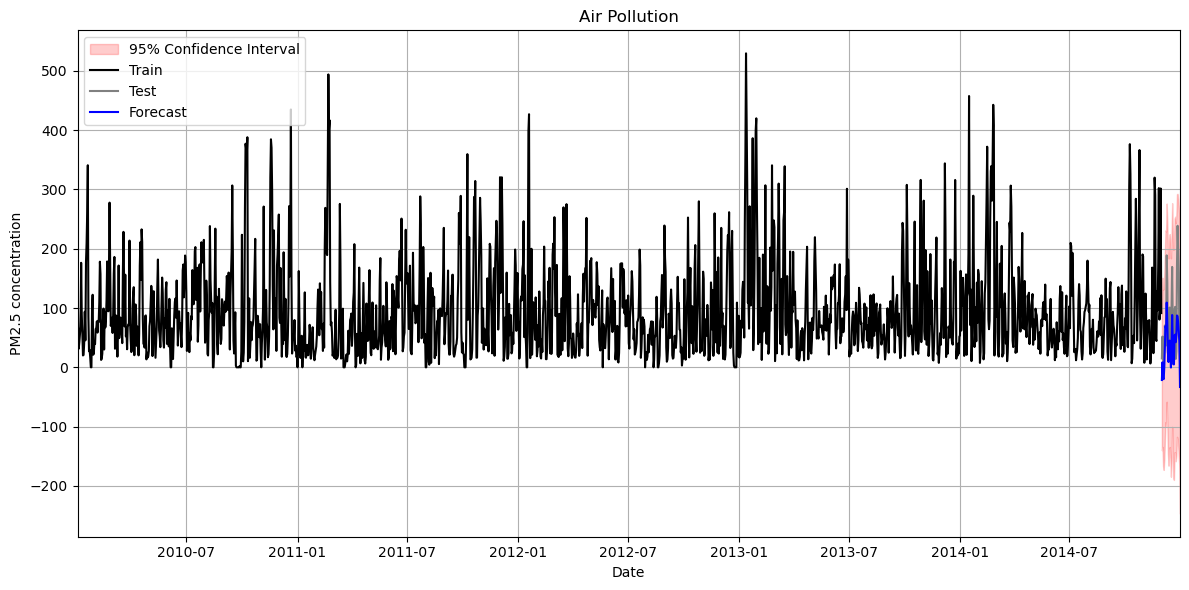

In [45]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['pollution'], label='Train', color='black')      # Train
plt.plot(test.index, test['pollution'], label='Test', color='gray')          # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')     # Forecast

plt.title('Air Pollution')                      
plt.xlabel('Date')                                        
plt.ylabel('PM2.5 concentration')  
plt.xlim(pd.to_datetime('2010-01-02'), pd.to_datetime('2014-12-31'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

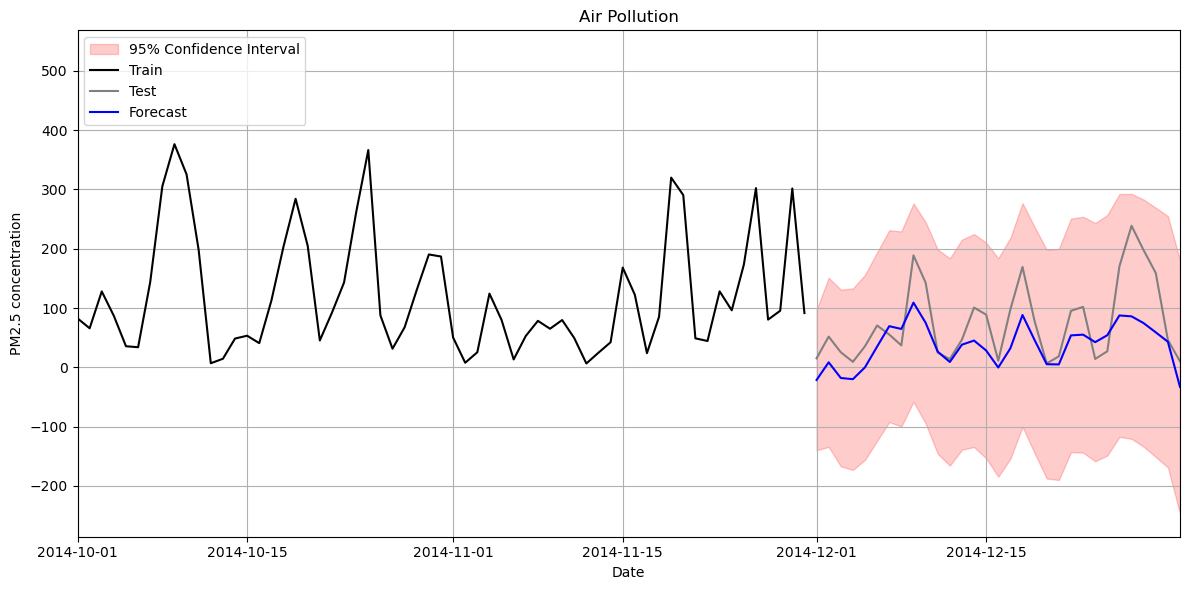

In [46]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['pollution'], label='Train', color='black')      # Train
plt.plot(test.index, test['pollution'], label='Test', color='gray')          # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')     # Forecast

plt.title('Air Pollution')                      
plt.xlabel('Date')                                        
plt.ylabel('PM2.5 concentration')  
plt.xlim(pd.to_datetime('2014-10-01'), pd.to_datetime('2014-12-31'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

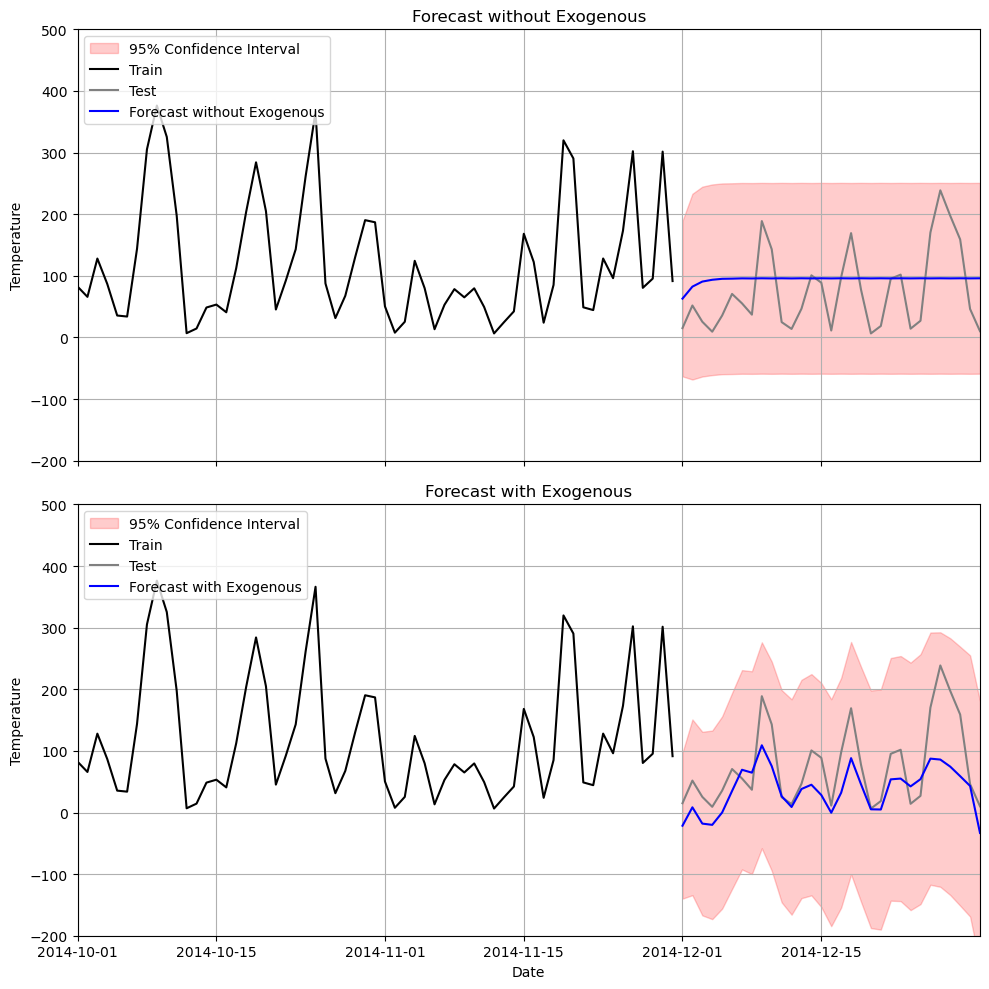

In [47]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast S) ---
axes[0].fill_between(test.index,
                     conf_int_S.iloc[:, 0],
                     conf_int_S.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['pollution'], label='Train', color='black')
axes[0].plot(test.index, test['pollution'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast without Exogenous', color='blue')

axes[0].set_title('Forecast without Exogenous')
axes[0].set_ylabel('Temperature')
axes[0].legend(loc=2)
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('2014-10-01'), pd.to_datetime('2014-12-31'))
axes[0].set_ylim(-200, 500)

# --- Second Forecast (Forecast M) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train.index, train['pollution'], label='Train', color='black')
axes[1].plot(test.index, test['pollution'], label='Test', color='gray')
axes[1].plot(test.index, test['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature')
axes[1].legend(loc=2)
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('2014-10-01'), pd.to_datetime('2014-12-31'))
axes[1].set_ylim(-200, 500)

# Final layout
plt.tight_layout()
plt.show()

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast without Exo
mae_s = mean_absolute_error(test['temp'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['temp'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['temp'], test['Forecast S']) * 100

# Metrics for Forecast with Exo
mae_m = mean_absolute_error(test['temp'], test['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test['temp'], test['Forecast M']))
mape_m = mean_absolute_percentage_error(test['temp'], test['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    #'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    #'MAPE': mape_m,
}

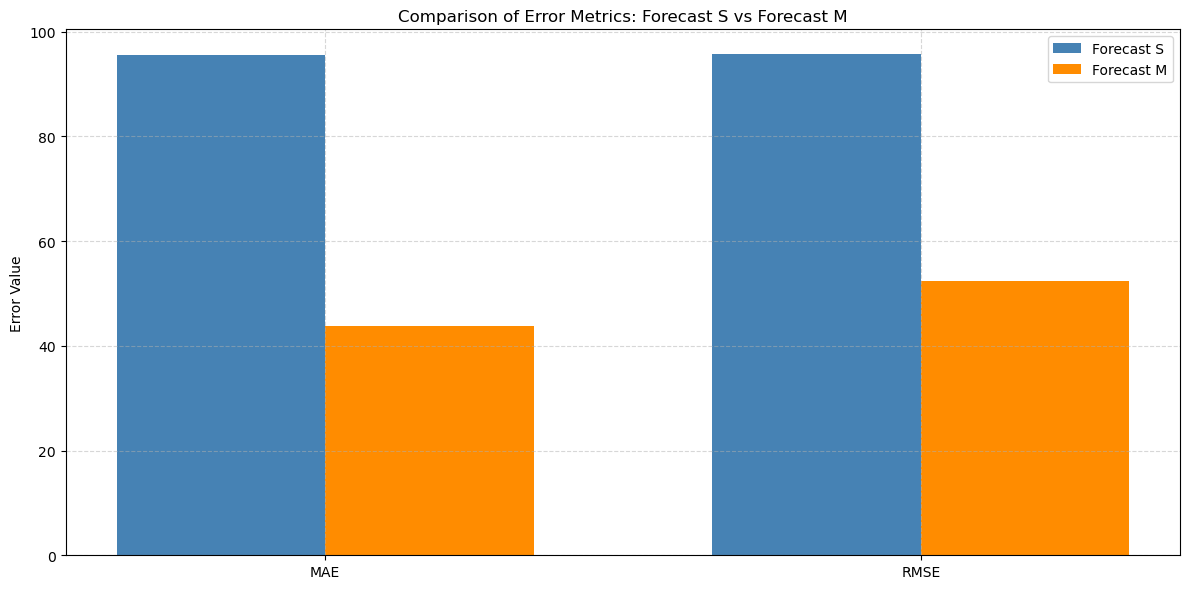

In [49]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [50]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,95.47,43.74
RMSE,95.64,52.37


End.